In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
movies = pd.read_csv('imdb-cleaned.csv')

In [4]:
movies['total_votes'] = movies.loc[:, 'rating_1':'rating_10'].sum(axis='columns')

We made a variable `total_votes` with the total number of user votes.

In [5]:
def calc_unweighted_rating(row):
    return sum([i * row[f'rating_{i}'] for i in range(1, 11)]) / row['total_votes']

movies['unweighted_rating'] = movies.apply(calc_unweighted_rating, axis='columns')

In [6]:
def calc_polarization(row):
    total_score = 0
    for rating_1 in range(1, 11):
        for rating_2 in range(rating_1 + 1, 11):
            total_score += row[f'rating_{rating_1}'] / row['total_votes'] * row[f'rating_{rating_2}'] / row['total_votes'] * (rating_2 - rating_1)

    return total_score

In [7]:
movies['polarization_score'] = movies.apply(calc_polarization, axis='columns')

We made a variable `polarization_score` with the polarization score calculated using Esteban and Ray's algorithm.

In [8]:
def calc_country_rating(country_idx, row):
    total_rating = 0
    total_votes = 0
    for rating in range(1, 11):
        total_rating += rating * row[f'country_{country_idx}_rating_{rating}']
        total_votes += row[f'country_{country_idx}_rating_{rating}']
    return total_rating / total_votes

In [9]:
for i in range(5):
    movies[f'country_{i}_rating'] = movies.apply(lambda row: calc_country_rating(i, row), axis='columns')

In [10]:
def calc_ptp(row):
    ptp = np.ptp(row.loc['country_0_rating':'country_4_rating'])

    max_country_idx = np.argmax(row.loc['country_0_rating':'country_4_rating'])
    min_country_idx = np.argmin(row.loc['country_0_rating':'country_4_rating'])
    max_country = row[f'country_{max_country_idx}']
    min_country = row[f'country_{min_country_idx}']

    return pd.Series([ptp, max_country, min_country])

In [11]:
movies[['country_ptp', 'max_country_ptp', 'min_country_ptp']] = movies.apply(calc_ptp, axis='columns')

We made a variable `country_ptp` with the difference between the highest and lowest average ratings between the top five countries with the most votes. The variables `max_country_ptp` and `min_country_ptp` record the country codes of the two countries with the highest and lowest ratings, respectively.

# EDA

In [12]:
movies.sort_values('country_ptp', ascending=False).head(25)

,id,title,genres,weighted_rating,release_year,gross,rating_1,rating_2,rating_3,rating_4,...,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp
3314,tt4776998,The Promise,"Action,Adventure,Drama",6.1,2017,"$8,224,288",71664,785,464,775,...,6.016163,2.203718,8.853424,1.372856,9.621135,7.973952,9.920069,8.547214,AM,TR
4299,tt11555492,Farha,Drama,8.0,2022,NaN,9534,177,97,127,...,8.871703,0.981824,9.418896,2.721110,9.675454,9.617452,9.901685,7.180575,JO,IL
4326,tt7668842,Enes Batur: Imagination or Reality?,Comedy,2.0,2018,NaN,21542,748,526,347,...,6.229664,2.186839,5.369399,3.201413,7.219048,3.030189,9.915730,6.885542,MY,GB
4322,tt10554232,Dara of Jasenovac,"Drama,War",8.1,2021,"$52,786",3818,262,176,200,...,9.395185,0.560421,9.872591,9.197059,9.094617,9.785560,3.023002,6.849588,RS,HR
4314,tt27719898,Kaiva,"Action,Drama,Romance",8.5,2023,NaN,7908,1162,16,28,...,8.598857,1.159006,8.632270,5.288793,7.434343,2.772727,2.846154,5.859543,IN,CA
4271,tt15979666,The Archies,"Comedy,Drama,Musical",4.2,2023,NaN,7096,918,579,601,...,8.019633,1.472463,8.523331,3.764650,3.804031,4.066975,3.327014,5.196317,IN,CA
2683,tt0077928,Midnight Express,"Biography,Crime,Drama",7.5,1978,"$35,000,000",5628,684,675,1175,...,7.295586,1.065465,7.436350,7.554844,3.224610,8.212210,7.648483,4.987600,GR,TR
4272,tt9637132,Samrat Prithviraj,"Action,Drama,History",5.6,2022,NaN,7574,964,586,637,...,7.959218,1.497891,8.384095,5.233802,5.597938,3.492119,4.573034,4.891976,IN,BD
7,tt20221436,Emilia Pérez,"Comedy,Crime,Drama",5.5,2024,NaN,24930,3995,3366,3753,...,4.491042,1.737361,4.775475,2.465527,1.949050,5.211796,6.801721,4.852670,FR,MX
4328,tt10280276,Coolie No. 1,"Action,Comedy,Romance",4.2,2020,NaN,46055,1455,760,576,...,3.828636,1.910510,3.133739,6.429201,1.851842,4.394161,1.663772,4.765429,US,CA


In [13]:
movies = movies.sort_values('polarization_score', ascending=False)

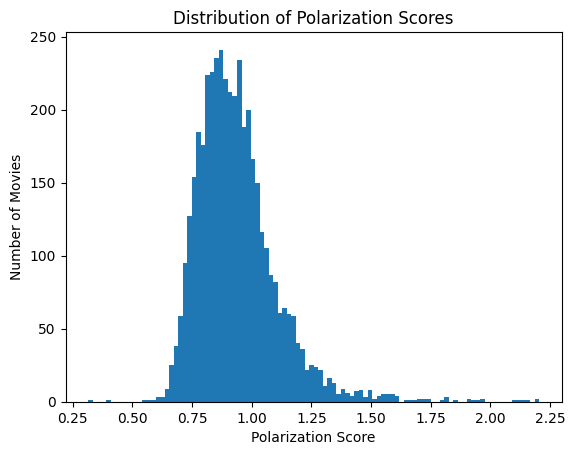

In [14]:
plt.hist(movies['polarization_score'], bins=100)
plt.xlabel('Polarization Score')
plt.ylabel('Number of Movies')
plt.title('Distribution of Polarization Scores')
plt.show()

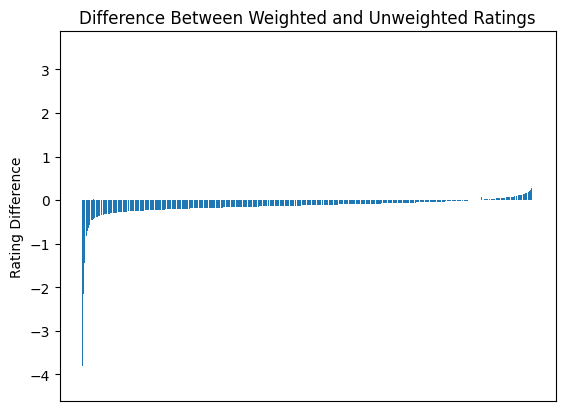

In [15]:
movies['rating_diff'] = movies['weighted_rating'] - movies['unweighted_rating']
sorted_movies = movies.sort_values('rating_diff', ascending=True)

plt.bar(sorted_movies['title'], sorted_movies['rating_diff'])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Rating Difference')
plt.title('Difference Between Weighted and Unweighted Ratings')
plt.show()

In [16]:
movies

,id,title,genres,weighted_rating,release_year,gross,rating_1,rating_2,rating_3,rating_4,...,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff
3314,tt4776998,The Promise,"Action,Adventure,Drama",6.1,2017,"$8,224,288",71664,785,464,775,...,2.203718,8.853424,1.372856,9.621135,7.973952,9.920069,8.547214,AM,TR,0.083837
4326,tt7668842,Enes Batur: Imagination or Reality?,Comedy,2.0,2018,NaN,21542,748,526,347,...,2.186839,5.369399,3.201413,7.219048,3.030189,9.915730,6.885542,MY,GB,-4.229664
4283,tt6277462,Brahmastra Part One: Shiva,"Action,Adventure,Fantasy",5.6,2022,"$7,839,108",42059,3965,2358,2499,...,2.150143,5.454443,5.112881,5.149154,6.204458,5.135355,1.091577,BD,US,0.167459
3628,tt26932223,Bhool Bhulaiyaa 3,"Comedy,Fantasy,Horror",4.7,2024,"$2,230,000",22601,5180,4905,3708,...,2.138212,5.708858,4.762722,4.927294,4.977181,5.146530,0.946136,IN,US,-0.945906
4305,tt12915716,Adipurush,"Action,Drama",2.7,2023,NaN,51121,3081,1575,1054,...,2.120026,6.059150,2.978719,2.793604,2.145765,1.755344,4.303805,IN,NP,-2.983395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4276,tt9263550,Rocketry: The Nambi Effect,"Biography,Drama",8.7,2022,NaN,1065,189,145,206,...,0.587468,9.488745,8.889562,9.089944,8.450251,8.832845,1.038494,IN,BD,-0.587875
4109,tt10811166,The Kashmir Files,Drama,8.5,2022,"$1,485,000",32018,1558,911,744,...,0.563224,9.495357,9.208485,9.228509,6.867313,9.059650,2.628045,IN,BD,-0.894972
4322,tt10554232,Dara of Jasenovac,"Drama,War",8.1,2021,"$52,786",3818,262,176,200,...,0.560421,9.872591,9.197059,9.094617,9.785560,3.023002,6.849588,RS,HR,-1.295185
5,tt14961016,I'm Still Here,"Biography,Drama,History",8.7,2025,"$6,147,824",1017,127,72,110,...,0.395623,9.718968,8.642775,9.025674,8.756312,9.048101,1.076193,BR,US,-0.853883


In [17]:
movies_us_release = movies[movies['gross'].notna()]

In [18]:
movies_us_release['gross'] = movies_us_release['gross'].str[1:]

<ipython-input-18-7cb8ed5b5dd3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_us_release['gross'] = movies_us_release['gross'].str[1:]


In [19]:
movies_us_release['gross'] = movies_us_release['gross'].apply(lambda x: x.replace(",", ""))

<ipython-input-19-b94924ed6b05>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_us_release['gross'] = movies_us_release['gross'].apply(lambda x: x.replace(",", ""))


In [20]:
movies_us_release = movies_us_release[movies_us_release['gross'] != '']
movies_us_release['gross'] = movies_us_release['gross'].astype('int')

<ipython-input-20-ecb60ec201a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_us_release['gross'] = movies_us_release['gross'].astype('int')


In [21]:
movies_us_release.sort_values('gross', ascending=False)

,id,title,genres,weighted_rating,release_year,gross,rating_1,rating_2,rating_3,rating_4,...,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff
767,tt2488496,Star Wars: Episode VII - The Force Awakens,"Action,Adventure,Sci-Fi",7.8,2015,936662225,27880,9629,12221,18447,...,1.031127,7.776843,7.760589,7.420518,7.280387,7.521980,0.496456,US,TR,0.146259
95,tt4154796,Avengers: Endgame,"Action,Adventure,Sci-Fi",8.4,2019,858373000,37552,6721,8475,12789,...,0.960545,8.319547,8.490176,8.927546,7.927010,8.095980,1.000535,IN,TR,0.074429
148,tt10872600,Spider-Man: No Way Home,"Action,Adventure,Fantasy",8.2,2021,804793477,17737,4207,5757,9018,...,0.920455,8.474646,8.417075,8.825519,7.998644,8.019018,0.826875,IN,TR,-0.090365
385,tt0499549,Avatar,"Action,Adventure,Fantasy",7.9,2009,749766139,29948,11717,16468,26200,...,1.010342,7.699379,7.632075,7.988966,7.749701,8.536487,0.904413,IN,GB,0.072631
54,tt1745960,Top Gun: Maverick,"Action,Drama",8.2,2022,718732821,6177,2357,3276,5205,...,0.784538,8.508100,8.410390,8.822344,8.074761,8.637722,0.747584,IN,DE,-0.163157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,tt0861739,Elite Squad,"Action,Crime,Drama",8.0,2007,8744,1346,353,517,869,...,0.791015,8.794319,7.663049,8.429045,7.835516,7.773234,1.131271,BR,US,-0.154094
916,tt1020530,Eden Lake,"Horror,Thriller",6.7,2008,7321,3225,1561,2267,3617,...,1.014029,6.632187,6.814292,6.836440,6.459950,6.804955,0.376491,DE,SE,-0.027517
2569,tt1439572,Perfect Sense,"Drama,Romance,Sci-Fi",7.0,2011,2959,1011,710,964,1765,...,0.964376,7.060834,7.279771,7.066603,7.182347,7.843495,0.782661,RO,US,-0.201081
2889,tt0210070,Ginger Snaps,"Drama,Fantasy,Horror",6.8,2001,2554,970,662,925,1889,...,1.009093,7.186017,7.001873,7.347732,6.715443,7.021930,0.632289,CA,DE,-0.207440


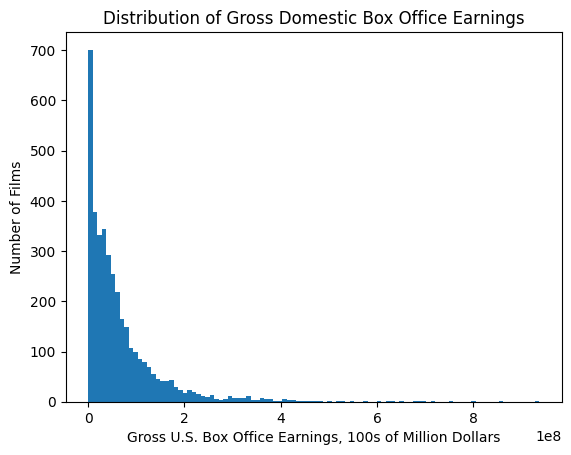

In [24]:
plt.hist(movies_us_release['gross'], bins=100)
plt.xlabel('Gross U.S. Box Office Earnings, 100s of Million Dollars')
plt.ylabel('Number of Films')
plt.title('Distribution of Gross Domestic Box Office Earnings')
plt.show()

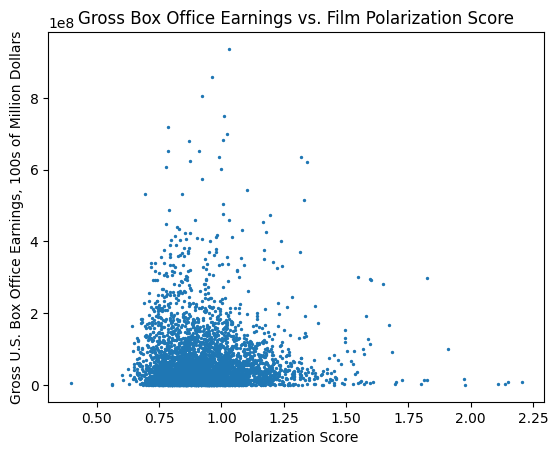

In [51]:
plt.scatter(movies_us_release['polarization_score'], movies_us_release['gross'], s=2)
plt.xlabel('Polarization Score')
plt.ylabel('Gross U.S. Box Office Earnings, 100s of Million Dollars')
plt.title('Gross Box Office Earnings vs. Film Polarization Score')
plt.show()

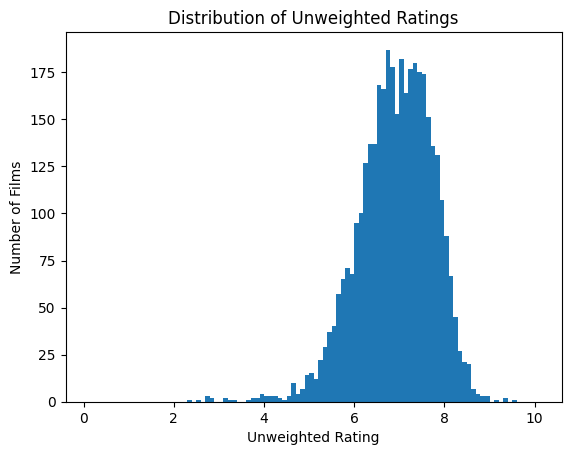

In [52]:
#define bins at each hundredth between 0 and 10
my_bins = [0.1]
for i in range(100):
    my_bins.append(my_bins[i] + 0.1)

plt.hist(movies_us_release['unweighted_rating'], bins=my_bins)
plt.xlabel('Unweighted Rating')
plt.ylabel('Number of Films')
plt.title('Distribution of Unweighted Ratings')
plt.show()

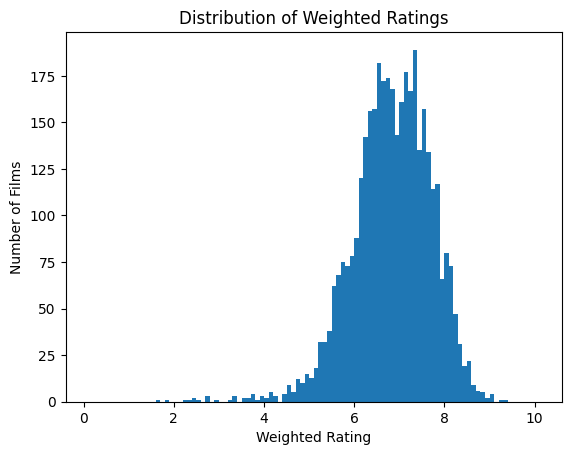

In [53]:
plt.hist(movies_us_release['weighted_rating'], bins=my_bins)
plt.xlabel('Weighted Rating')
plt.ylabel('Number of Films')
plt.title('Distribution of Weighted Ratings')
plt.show()

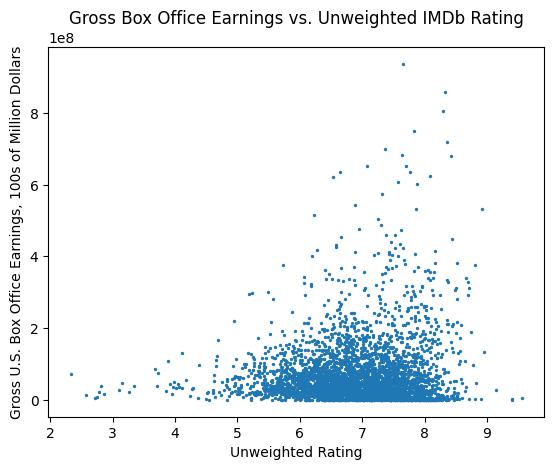

In [54]:
plt.scatter(movies_us_release['unweighted_rating'], movies_us_release['gross'], s=2)
plt.xlabel('Unweighted Rating')
plt.ylabel('Gross U.S. Box Office Earnings, 100s of Million Dollars')
plt.title('Gross Box Office Earnings vs. Unweighted IMDb Rating')
plt.show()

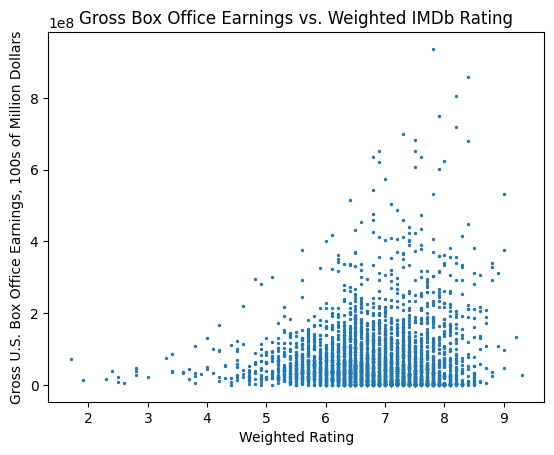

In [55]:
plt.scatter(movies_us_release['weighted_rating'], movies_us_release['gross'], s=2)
plt.xlabel('Weighted Rating')
plt.ylabel('Gross U.S. Box Office Earnings, 100s of Million Dollars')
plt.title('Gross Box Office Earnings vs. Weighted IMDb Rating')
plt.show()

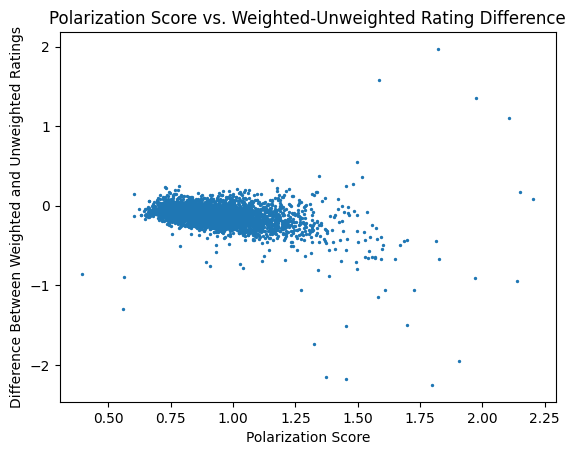

In [57]:
plt.scatter(movies_us_release['polarization_score'], movies_us_release['rating_diff'], s=2)
plt.ylabel('Difference Between Weighted and Unweighted Ratings')
plt.xlabel('Polarization Score')
plt.title('Polarization Score vs. Weighted-Unweighted Rating Difference')
plt.show()